# 악성 댓글 구분하기

In [ ]:
!pip install transformers
!pip install datasets==1.17.0

### 데이터 읽어오기

In [2]:
from datasets import load_dataset
datasets = load_dataset('smilegate-ai/kor_unsmile')

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Using custom data configuration smilegate-ai--kor_unsmile-1dba960877497f9f


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/290k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/smilegate-ai--kor_unsmile-1dba960877497f9f/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
print(datasets)

DatasetDict({
    train: Dataset({
        features: ['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭', 'labels'],
        num_rows: 15005
    })
    valid: Dataset({
        features: ['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭', 'labels'],
        num_rows: 3737
    })
})


In [4]:
import pandas as pd

In [5]:
train_df = pd.DataFrame(datasets["train"])
valid_df = pd.DataFrame(datasets["valid"])
train_df.shape, valid_df.shape

((15005, 13), (3737, 13))

### 데이터 전처리

In [6]:
train_df.isna().sum()

문장        0
여성/가족     0
남성        0
성소수자      0
인종/국적     0
연령        0
지역        0
종교        0
기타 혐오     0
악플/욕설     0
clean     0
개인지칭      0
labels    0
dtype: int64

In [7]:
valid_df.isna().sum()

문장        0
여성/가족     0
남성        0
성소수자      0
인종/국적     0
연령        0
지역        0
종교        0
기타 혐오     0
악플/욕설     0
clean     0
개인지칭      0
labels    0
dtype: int64

In [8]:
# train_df shape : (15005, 13) 이므로 중복 1개 존재
train_df.문장.nunique()

15004

In [9]:
# valid df shape : (3737, 13) 중복이 존재하지 않음
valid_df.문장.nunique()

3737

In [10]:
train_df.drop_duplicates(subset=['문장'], inplace=True) 
train_df.shape

(15004, 13)

In [11]:
# 악성댓글이면 0, 아니면 1
train_df.clean.value_counts()

0    11266
1     3738
Name: clean, dtype: int64

In [12]:
valid_df.clean.value_counts()

0    2802
1     935
Name: clean, dtype: int64

### 텍스트 전처리

In [13]:
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

In [14]:
train_df.문장 = train_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.문장.replace('', np.nan, inplace=True)
train_df.dropna(how='any', inplace=True)
train_df.shape
# 24개 제거

(14980, 13)

In [15]:
valid_df.문장 = valid_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
valid_df.문장.replace('', np.nan, inplace=True)
valid_df.dropna(how='any', inplace=True)
valid_df.shape
# 7개 제거

(3730, 13)

### 형태소 분석 & 정수 인코딩


#### Tokenizer : Okt

In [16]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 55.3 MB/s 


In [17]:
from konlpy.tag import Okt
from tqdm.notebook import tqdm

okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [18]:
X_train = []
for sentence in tqdm(train_df.문장):
    morphs = okt.morphs(sentence, stem=True)
    tmp_X = [word for word in morphs if word not in stopwords]
    X_train.append(tmp_X)

  0%|          | 0/14980 [00:00<?, ?it/s]

In [19]:
X_test = []
for sentence in tqdm(valid_df.문장):
    morphs = okt.morphs(sentence, stem=True)
    tmp_X = [word for word in morphs if word not in stopwords]
    X_test.append(tmp_X)

  0%|          | 0/3730 [00:00<?, ?it/s]

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

threshold = 10
total_cnt = len(t.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in t.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18075
등장 빈도가 9번 이하인 희귀 단어의 수: 15478
단어 집합에서 희귀 단어의 비율: 85.63208852005533
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 17.798475243771456


In [21]:
# 모든 단어를 사용하기로 결정
vocab_size = total_cnt + 1
print(vocab_size)

18076


In [22]:
t = Tokenizer()
t.fit_on_texts(X_train)
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
y_train = np.array(train_df[['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']])
y_test = np.array(valid_df[['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']])

y_train.shape, y_test.shape

((14980, 10), (3730, 10))

In [23]:
# 빈 샘플들을 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

14978
14978


### 패딩

리뷰의 최대 길이_Okt ver : 72
리뷰의 평균 길이_Okt ver : 12.680731739885164


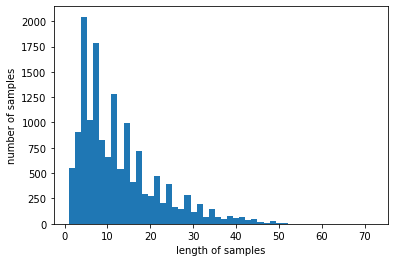

In [24]:
import matplotlib.pyplot as plt
print('리뷰의 최대 길이_Okt ver :',max(len(review) for review in X_train))
print('리뷰의 평균 길이_Okt ver :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [26]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.08465749766324


In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape, X_test.shape

((14978, 30), (3730, 30))

### 모델 생성 및 분류하기

#### 1. LSTM

In [69]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [70]:
model1 = Sequential([ 
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(128),
    Dense(10, activation='softmax')
])
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 30, 128)           2313728   
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,446,602
Trainable params: 2,446,602
Non-trainable params: 0
_________________________________________________________________


In [71]:
model1.compile('adam', 'categorical_crossentropy', ['accuracy'])
model1_path = 'unsmile_lstm.h5'
mc1 = ModelCheckpoint(model1_path, verbose=1, save_best_only=True)
es1 = EarlyStopping(patience=5)

In [72]:
hist1 = model1.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc1, es1]
)

Epoch 1/100
183/188 [============================>.] - ETA: 0s - loss: 2.1138 - accuracy: 0.3063
Epoch 1: val_loss improved from inf to 1.72607, saving model to unsmile_lstm.h5
188/188 [==============================] - 4s 11ms/step - loss: 2.1086 - accuracy: 0.3087 - val_loss: 1.7261 - val_accuracy: 0.4499
Epoch 2/100
181/188 [===========================>..] - ETA: 0s - loss: 1.3769 - accuracy: 0.5969
Epoch 2: val_loss improved from 1.72607 to 1.40379, saving model to unsmile_lstm.h5
188/188 [==============================] - 1s 8ms/step - loss: 1.3745 - accuracy: 0.5980 - val_loss: 1.4038 - val_accuracy: 0.5958
Epoch 3/100
181/188 [===========================>..] - ETA: 0s - loss: 0.9236 - accuracy: 0.7649
Epoch 3: val_loss did not improve from 1.40379
188/188 [==============================] - 1s 8ms/step - loss: 0.9235 - accuracy: 0.7644 - val_loss: 1.4497 - val_accuracy: 0.6278
Epoch 4/100
184/188 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.8419
Epoch 4

In [73]:
best_model1 = load_model(model1_path)
loss1, acc1 = best_model1.evaluate(X_test, y_test)
loss1, acc1

117/117 [==============================] - 1s 4ms/step - loss: 1.3576 - accuracy: 0.6067


(1.3576472997665405, 0.6067023873329163)

#### 2. Conv1D + LSTM

In [74]:
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D

In [75]:
model2 = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Dropout(0.2),
    Conv1D(256, 3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=4),
    LSTM(128),
    Dense(10, activation='softmax')
])
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 30, 128)           2313728   
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 28, 256)           98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 256)           0         
 1D)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 128)               197120    
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                      

In [76]:
model2.compile('adam', 'categorical_crossentropy', ['accuracy'])
model2_path = 'unsmile_conv1d_lstm.h5'
mc2 = ModelCheckpoint(model2_path, verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=5)

In [77]:
hist2 = model2.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc2, es2]
)

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 2.0233 - accuracy: 0.3408
Epoch 1: val_loss improved from inf to 1.61983, saving model to unsmile_conv1d_lstm.h5
188/188 [==============================] - 4s 11ms/step - loss: 2.0233 - accuracy: 0.3408 - val_loss: 1.6198 - val_accuracy: 0.4793
Epoch 2/100
182/188 [============================>.] - ETA: 0s - loss: 1.3057 - accuracy: 0.6292
Epoch 2: val_loss improved from 1.61983 to 1.33838, saving model to unsmile_conv1d_lstm.h5
188/188 [==============================] - 1s 8ms/step - loss: 1.2994 - accuracy: 0.6301 - val_loss: 1.3384 - val_accuracy: 0.6215
Epoch 3/100
184/188 [============================>.] - ETA: 0s - loss: 0.8328 - accuracy: 0.7920
Epoch 3: val_loss did not improve from 1.33838
188/188 [==============================] - 1s 7ms/step - loss: 0.8331 - accuracy: 0.7922 - val_loss: 1.5119 - val_accuracy: 0.6128
Epoch 4/100
182/188 [============================>.] - ETA: 0s - loss: 0.5673 - accuracy: 

In [78]:
best_model2 = load_model(model2_path)
loss2, acc2 = best_model2.evaluate(X_test, y_test)
loss2, acc2

117/117 [==============================] - 1s 3ms/step - loss: 1.2843 - accuracy: 0.6327


(1.2842955589294434, 0.6327077746391296)

#### 3. BiLSTM

In [79]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D

In [80]:
model3 = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(10, activation='softmax')
])

model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 30, 128)           2313728   
                                                                 
 bidirectional_4 (Bidirectio  (None, 30, 256)          263168    
 nal)                                                            
                                                                 
 global_max_pooling1d_4 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2,579,466
Trainable params: 2,579,466
Non-trainable params: 0
_________________________________________________________________


In [81]:
model3.compile('adam', 'categorical_crossentropy', ['accuracy'])
model3_path = 'unsmile_bilstm.h5'
mc3 = ModelCheckpoint(model3_path, verbose=1, save_best_only=True)
es3 = EarlyStopping(patience=5)

In [82]:
hist3 = model3.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc3, es3]
)

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 2.1234 - accuracy: 0.3099
Epoch 1: val_loss improved from inf to 1.87705, saving model to unsmile_bilstm.h5
188/188 [==============================] - 9s 16ms/step - loss: 2.1234 - accuracy: 0.3099 - val_loss: 1.8771 - val_accuracy: 0.3862
Epoch 2/100
187/188 [============================>.] - ETA: 0s - loss: 1.4993 - accuracy: 0.5514
Epoch 2: val_loss improved from 1.87705 to 1.42850, saving model to unsmile_bilstm.h5
188/188 [==============================] - 2s 12ms/step - loss: 1.4990 - accuracy: 0.5516 - val_loss: 1.4285 - val_accuracy: 0.5668
Epoch 3/100
184/188 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.7227
Epoch 3: val_loss improved from 1.42850 to 1.34152, saving model to unsmile_bilstm.h5
188/188 [==============================] - 2s 13ms/step - loss: 1.0418 - accuracy: 0.7218 - val_loss: 1.3415 - val_accuracy: 0.6138
Epoch 4/100
183/188 [============================>.] - ETA:

In [83]:
best_model3 = load_model(model3_path)
loss3, acc3 = best_model3.evaluate(X_test, y_test)
loss3, acc3

117/117 [==============================] - 1s 5ms/step - loss: 1.2899 - accuracy: 0.6362


(1.289940595626831, 0.636193037033081)

#### 4. Conv1D + BiLSTM

In [84]:
model4 = Sequential([                 
                     
    Embedding(vocab_size, 128, input_length=max_len),
    Dropout(0.2),
    Conv1D(256, 3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=4),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(10, activation='softmax')
])

model4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 30, 128)           2313728   
                                                                 
 dropout_4 (Dropout)         (None, 30, 128)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 28, 256)           98560     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 7, 256)           0         
 1D)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 7, 256)           394240    
 nal)                                                            
                                                                 
 global_max_pooling1d_5 (Glo  (None, 256)            

In [85]:
model4.compile('adam', 'categorical_crossentropy', ['accuracy'])
model4_path = 'unsmile_conv1d_bilstm.h5'
mc4 = ModelCheckpoint(model4_path, verbose=1, save_best_only=True)
es4 = EarlyStopping(patience=5)

In [86]:
hist4 = model4.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc4, es4]
)

Epoch 1/100
186/188 [============================>.] - ETA: 0s - loss: 2.1045 - accuracy: 0.3168
Epoch 1: val_loss improved from inf to 1.80055, saving model to unsmile_conv1d_bilstm.h5
188/188 [==============================] - 6s 14ms/step - loss: 2.1026 - accuracy: 0.3176 - val_loss: 1.8005 - val_accuracy: 0.4453
Epoch 2/100
188/188 [==============================] - ETA: 0s - loss: 1.4286 - accuracy: 0.5805
Epoch 2: val_loss improved from 1.80055 to 1.43511, saving model to unsmile_conv1d_bilstm.h5
188/188 [==============================] - 2s 10ms/step - loss: 1.4286 - accuracy: 0.5805 - val_loss: 1.4351 - val_accuracy: 0.5908
Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 1.0065 - accuracy: 0.7342
Epoch 3: val_loss did not improve from 1.43511
188/188 [==============================] - 2s 10ms/step - loss: 1.0065 - accuracy: 0.7342 - val_loss: 1.4858 - val_accuracy: 0.5868
Epoch 4/100
183/188 [============================>.] - ETA: 0s - loss: 0.7664 - accu

In [87]:
best_model4 = load_model(model4_path)
loss4, acc4 = best_model4.evaluate(X_test, y_test)
loss4, acc4

117/117 [==============================] - 1s 4ms/step - loss: 1.4096 - accuracy: 0.5885


(1.4096407890319824, 0.5884718298912048)

#### 5. GRU

In [88]:
from tensorflow.keras.layers import GRU

In [89]:
model5 = Sequential([ 
    Embedding(vocab_size, 128, input_length=max_len),
    GRU(128),
    Dense(10, activation='softmax')
])
model5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 30, 128)           2313728   
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 2,414,090
Trainable params: 2,414,090
Non-trainable params: 0
_________________________________________________________________


In [90]:
model5.compile('adam', 'categorical_crossentropy', ['accuracy'])
model5_path = 'unsmile_gru.h5'
mc5 = ModelCheckpoint(model5_path, verbose=1, save_best_only=True)
es5 = EarlyStopping(patience=5)

In [91]:
hist5 = model5.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc5, es5]
)

Epoch 1/100
181/188 [===========================>..] - ETA: 0s - loss: 2.0584 - accuracy: 0.3358
Epoch 1: val_loss improved from inf to 1.57874, saving model to unsmile_gru.h5
188/188 [==============================] - 4s 11ms/step - loss: 2.0460 - accuracy: 0.3413 - val_loss: 1.5787 - val_accuracy: 0.5344
Epoch 2/100
180/188 [===========================>..] - ETA: 0s - loss: 1.2956 - accuracy: 0.6456
Epoch 2: val_loss improved from 1.57874 to 1.41960, saving model to unsmile_gru.h5
188/188 [==============================] - 1s 8ms/step - loss: 1.2951 - accuracy: 0.6445 - val_loss: 1.4196 - val_accuracy: 0.6132
Epoch 3/100
184/188 [============================>.] - ETA: 0s - loss: 0.9288 - accuracy: 0.7617
Epoch 3: val_loss did not improve from 1.41960
188/188 [==============================] - 1s 7ms/step - loss: 0.9306 - accuracy: 0.7613 - val_loss: 1.4943 - val_accuracy: 0.6305
Epoch 4/100
185/188 [============================>.] - ETA: 0s - loss: 0.7342 - accuracy: 0.8296
Epoch 4: 

In [92]:
best_model5 = load_model(model5_path)
loss5, acc5 = best_model5.evaluate(X_test, y_test)
loss5, acc5

117/117 [==============================] - 1s 3ms/step - loss: 1.3644 - accuracy: 0.6193


(1.3643717765808105, 0.6193029284477234)

#### 6. Conv1D + GRU

In [93]:
model6 = Sequential([ 
    Embedding(vocab_size, 128, input_length=max_len),
    GRU(128),
    Dense(10, activation='softmax')
])
model6.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 30, 128)           2313728   
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dense_12 (Dense)            (None, 10)                1290      
                                                                 
Total params: 2,414,090
Trainable params: 2,414,090
Non-trainable params: 0
_________________________________________________________________


In [94]:
model6.compile('adam', 'categorical_crossentropy', ['accuracy'])
model6_path = 'unsmile_conv1d_gru.h5'
mc6 = ModelCheckpoint(model6_path, verbose=1, save_best_only=True)
es6 = EarlyStopping(patience=5)

In [95]:
hist6 = model6.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc6, es6]
)

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 2.0592 - accuracy: 0.3413
Epoch 1: val_loss improved from inf to 1.64342, saving model to unsmile_conv1d_gru.h5
188/188 [==============================] - 4s 11ms/step - loss: 2.0592 - accuracy: 0.3413 - val_loss: 1.6434 - val_accuracy: 0.4746
Epoch 2/100
183/188 [============================>.] - ETA: 0s - loss: 1.2490 - accuracy: 0.6575
Epoch 2: val_loss improved from 1.64342 to 1.33455, saving model to unsmile_conv1d_gru.h5
188/188 [==============================] - 1s 8ms/step - loss: 1.2452 - accuracy: 0.6584 - val_loss: 1.3346 - val_accuracy: 0.6325
Epoch 3/100
183/188 [============================>.] - ETA: 0s - loss: 0.8734 - accuracy: 0.7813
Epoch 3: val_loss did not improve from 1.33455
188/188 [==============================] - 1s 7ms/step - loss: 0.8752 - accuracy: 0.7807 - val_loss: 1.5114 - val_accuracy: 0.6255
Epoch 4/100
185/188 [============================>.] - ETA: 0s - loss: 0.7087 - accuracy: 0.

In [96]:
best_model6 = load_model(model6_path)
loss6, acc6 = best_model6.evaluate(X_test, y_test)
loss6, acc6

117/117 [==============================] - 1s 3ms/step - loss: 1.2919 - accuracy: 0.6445


(1.2919459342956543, 0.6445040106773376)

### 정확도 비교

In [97]:
print(f"LSTM : {loss1} / {acc1}")
print(f"Conv1D + LSTM : {loss2} / {acc2}")
print(f"BiLSTM : {loss3} / {acc3}")
print(f"Conv1D + BiLSTM : {loss4} / {acc4}")
print(f"GRU : {loss5} / {acc5}")
print(f"Conv1D + GRU : {loss6} / {acc6}")

LSTM : 1.3576472997665405 / 0.6067023873329163
Conv1D + LSTM : 1.2842955589294434 / 0.6327077746391296
BiLSTM : 1.289940595626831 / 0.636193037033081
Conv1D + BiLSTM : 1.4096407890319824 / 0.5884718298912048
GRU : 1.3643717765808105 / 0.6193029284477234
Conv1D + GRU : 1.2919459342956543 / 0.6445040106773376


### 실제 데이터 예측

In [98]:
import re
def unsmile_predict(model, new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = t.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  predicted = model.predict(pad_new) # 예측

  result=[]
  columns = ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']
  for i in range(len(predicted[0])):
    if predicted[0][i]>0.1:
      print(f"{columns[i]} ({predicted[0][i]*100:.2f}%)")

In [99]:
columns = ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']
for i in range(5,10):
  print(valid_df.문장[i])
  print("\n예측 결과 : ")
  unsmile_predict(best_model1, valid_df.문장[i])
  print("\n실제 결과 : ")
  for c in columns:
    if valid_df[c][i]==1:
      print(c)
  print("==========")

저새끼 슈스케나온새끼잖아 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

예측 결과 : 
인종/국적 (11.78%)
악플/욕설 (62.98%)
clean (12.98%)

실제 결과 : 
악플/욕설
모든 이슬람이 테러리스트는 아니지만 모든 테러리스트는 이슬람이다  자유민주국가에서 테러분자 감시는 텄고요  막는게 최선 아닌가요

예측 결과 : 
인종/국적 (31.70%)
종교 (56.87%)

실제 결과 : 
인종/국적
종교
또 남자네     역시 한남충들은     절레절레

예측 결과 : 
여성/가족 (19.82%)
남성 (55.92%)
성소수자 (11.43%)

실제 결과 : 
남성
그만해라 틀딱새끼들 달려와서 너 좆족으로 몰아간다 이제

예측 결과 : 
인종/국적 (22.45%)
연령 (32.31%)
종교 (25.85%)

실제 결과 : 
인종/국적
연령
잘생긴 형같음절대로 여자로 안보임 ㅇㅇ

예측 결과 : 
인종/국적 (13.01%)
악플/욕설 (20.98%)
clean (49.33%)

실제 결과 : 
여성/가족


In [100]:
sentence="이래서 여자는 게임을 하면 안된다"
print(sentence)
print("실제 결과 : ")
for c in columns:
  if valid_df[c][i]==1:
    print(c)

이래서 여자는 게임을 하면 안된다
실제 결과 : 
여성/가족


In [105]:
print("LSTM 예측 결과 : ")
unsmile_predict(best_model2, "이래서 여자는 게임을 하면 안된다")
print("==========")
print("Conv1D + LSTM 예측 결과 : ")
unsmile_predict(best_model2, "이래서 여자는 게임을 하면 안된다")
print("==========")
print("BiLSTM 예측 결과 : ")
unsmile_predict(best_model3, "이래서 여자는 게임을 하면 안된다")
print("==========")
print("Conv1D + BiLSTM 예측 결과 : ")
unsmile_predict(best_model4, "이래서 여자는 게임을 하면 안된다")
print("==========")
print("GRU 예측 결과 : ")
unsmile_predict(best_model5, "이래서 여자는 게임을 하면 안된다")
print("==========")
print("Conv1D + GRU 예측 결과 : ")
unsmile_predict(best_model6, "이래서 여자는 게임을 하면 안된다")
print("==========")

LSTM 예측 결과 : 
여성/가족 (19.48%)
악플/욕설 (40.02%)
clean (30.31%)
Conv1D + LSTM 예측 결과 : 
여성/가족 (19.48%)
악플/욕설 (40.02%)
clean (30.31%)
BiLSTM 예측 결과 : 
여성/가족 (42.36%)
악플/욕설 (18.84%)
clean (28.65%)
Conv1D + BiLSTM 예측 결과 : 
여성/가족 (38.04%)
악플/욕설 (23.41%)
clean (23.94%)
GRU 예측 결과 : 
여성/가족 (47.90%)
남성 (11.93%)
악플/욕설 (17.08%)
clean (20.61%)
Conv1D + GRU 예측 결과 : 
여성/가족 (63.46%)
clean (19.31%)
